In [20]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Pastel1'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'cg-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from cg-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(16396, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 40.6min


[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=23.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=23.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=23.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.511890, total=23.4min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=23.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=23.2min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=23.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 44.7min


[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=24.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=24.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.511890, total=24.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=24.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=24.7min
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=24.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=24.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=24.6min
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 45.8min


[CV] .............. C=0.01, gamma=0.001, score=0.886890, total=17.6min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.892683, total=17.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.899695, total=17.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.900305, total=17.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.903354, total=17.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.868902, total=20.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.848476, total=20.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 91.7min


[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=26.4min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=26.4min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=26.5min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=31.7min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=31.8min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=32.0min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=31.9min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 119.5min


[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=29.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.511890, total=30.4min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=30.3min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=29.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.511890, total=29.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=29.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.511890, total=30.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 146.2min


[CV] ............... C=0.1, gamma=1e-08, score=0.511890, total=25.8min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=34.2min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=34.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=34.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=34.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.511890, total=25.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=35.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 166.3min


[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=23.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=23.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=22.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=22.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.912500, total=13.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.915854, total=13.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.918293, total=14.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 186.0min


[CV] ............... C=0.1, gamma=1e-05, score=0.869512, total=23.6min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.856098, total=23.9min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=25.8min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=23.9min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=23.8min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=23.7min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=24.0min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 241.5min


[CV] ................. C=0.1, gamma=1.0, score=0.511890, total=49.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=43.8min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.511890, total=49.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.511890, total=49.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=48.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=48.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=100.0, score=0.511890, total=48.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 282.5min


[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=23.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=23.6min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=23.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.511890, total=25.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=25.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=25.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.511890, total=25.7min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 297.4min


[CV] ............... C=1.0, gamma=1e-06, score=0.849085, total=23.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.964634, total= 7.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.961890, total= 7.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.862500, total=23.5min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.861585, total=23.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.511890, total=25.5min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.965854, total= 7.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 370.9min


[CV] ................ C=1.0, gamma=10.0, score=0.516768, total=50.4min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.519512, total=57.3min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.519207, total=56.6min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.518293, total=56.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.516159, total=50.1min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.516768, total=50.4min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.516463, total=47.4min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 413.1min


[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=23.6min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.511890, total=23.4min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=25.7min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=25.6min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=25.7min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.511890, total=25.6min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.861585, total=21.2min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 425.5min


[CV] .............. C=10.0, gamma=1e-06, score=0.917073, total=11.9min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.946341, total= 6.5min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.969817, total= 6.6min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.962805, total= 6.5min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.970732, total= 7.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.970732, total= 7.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............... C=1.0, gamma=100.0, score=0.516159, total=51.8min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 540.3min


[CV] ................ C=10.0, gamma=1.0, score=0.516768, total=95.5min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.516159, total=96.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=100.0, score=0.516768, total=84.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.516768, total=89.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.1, score=0.519207, total=102.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.1, score=0.518902, total=103.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.516463, total=98.0min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 582.6min


[CV] ............. C=100.0, gamma=1e-07, score=0.917073, total=13.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-08, score=0.849390, total=21.4min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.953354, total= 4.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.862500, total=22.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.948780, total= 4.3min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.946646, total= 6.6min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.952439, total= 4.7min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 633.0min


[CV] ............. C=10.0, gamma=1000.0, score=0.516768, total=87.8min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=10.0, gamma=1000.0, score=0.516768, total=95.2min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=10.0, gamma=100.0, score=0.516159, total=100.7min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.516159, total=101.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.516463, total=103.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.734146, total=76.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.735976, total=76.2min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 733.8min


[CV] ............ C=1000.0, gamma=1e-08, score=0.917988, total=12.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.516768, total=83.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.922561, total=13.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.917073, total=12.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.941463, total= 6.5min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.946037, total= 4.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.951829, total= 4.8min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 752.9min


[CV] ........... C=1000.0, gamma=0.0001, score=0.957622, total= 4.4min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............. C=100.0, gamma=100.0, score=0.516768, total=97.3min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............. C=100.0, gamma=100.0, score=0.516768, total=88.5min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.969817, total= 7.1min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.962805, total= 7.2min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.971037, total= 7.4min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.970732, total= 7.5min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 877.9min


[CV] ............. C=1000.0, gamma=10.0, score=0.516159, total=96.2min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=0.1, score=0.519512, total=106.2min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.516463, total=98.3min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=1.0, score=0.516159, total=102.5min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.940244, total= 7.1min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............ C=1000.0, gamma=10.0, score=0.516768, total=104.0min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.940854, total= 6.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 903.5min


[CV] ........... C=10000.0, gamma=1e-05, score=0.944512, total= 4.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.954878, total= 4.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.953354, total= 4.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.961585, total= 4.4min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.961585, total= 4.1min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.957622, total= 4.2min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ............. C=1000.0, gamma=10.0, score=0.516768, total=89.4min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 1022.6min


[CV] ............. C=10000.0, gamma=1.0, score=0.516463, total=91.5min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.519207, total=103.0min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.516768, total=95.9min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.517073, total=96.1min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.519512, total=100.2min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.939329, total= 7.0min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.938720, total= 7.0min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 1052.4min


[CV] .......... C=100000.0, gamma=1e-05, score=0.946646, total= 4.1min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.944512, total= 4.0min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.953354, total= 4.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.961585, total= 4.5min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.954878, total= 4.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.961585, total= 4.5min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.957622, total= 4.4min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 1177.2min


[CV] ............ C=100000.0, gamma=1.0, score=0.516463, total=89.9min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.518902, total=96.7min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.518293, total=102.1min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.520122, total=101.7min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.951524, total= 4.3min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ............ C=100000.0, gamma=1.0, score=0.517073, total=96.0min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.946646, total= 4.4min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 1206.8min


[CV] ........ C=1000000.0, gamma=0.0001, score=0.961585, total= 4.2min
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.953354, total= 4.2min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.954878, total= 4.2min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.957622, total= 4.2min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.961585, total= 4.4min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] .......... C=100000.0, gamma=10.0, score=0.516159, total=101.3min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=0.001, score=0.962805, total= 7.4min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 1341.9min


[CV] .......... C=1000000.0, gamma=0.1, score=0.519207, total=102.5min
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.517073, total=96.5min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.950000, total= 3.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.516463, total=96.3min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.946951, total= 3.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.945427, total= 3.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=0.1, score=0.519512, total=105.9min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 1367.2min


[CV] ....... C=10000000.0, gamma=0.0001, score=0.957622, total= 4.5min
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] .......... C=1000000.0, gamma=10.0, score=0.516768, total=83.9min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.969817, total= 7.6min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.962805, total= 7.5min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.971037, total= 7.1min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.970732, total= 7.1min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.970427, total= 7.1min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 1498.5min


[CV] ....... C=100000000.0, gamma=1e-09, score=0.948171, total= 3.7min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-09, score=0.950000, total= 3.5min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.936890, total= 4.3min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.931098, total= 4.8min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.935976, total= 4.9min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.923780, total= 5.2min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.937195, total= 4.6min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 1527.7min


[CV] ........ C=10000000.0, gamma=100.0, score=0.516768, total=95.8min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ........ C=10000000.0, gamma=10.0, score=0.516159, total=101.8min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.516159, total=102.5min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=10000000.0, gamma=100.0, score=0.516768, total=79.3min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.516463, total=106.8min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=1000.0, score=0.516768, total=92.8min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ...... C=10000000.0, gamma=1000.0, score=0.516159, total=106.4min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 1656.1min


[CV] ...... C=1000000000.0, gamma=1e-07, score=0.939939, total= 3.6min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.939634, total= 3.8min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.939024, total= 3.7min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.936890, total= 3.9min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.938415, total= 3.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.934756, total= 4.0min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.939939, total= 3.9min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 1760.6min


[CV] ....... C=1000000000.0, gamma=0.01, score=0.737805, total=75.5min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.734146, total=81.1min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.750305, total=80.6min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.518293, total=94.6min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.520122, total=95.1min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.519207, total=95.6min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.518902, total=96.5min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 1867.9min


[CV] .... C=10000000000.0, gamma=0.0001, score=0.954878, total= 9.2min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.961585, total= 9.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ...... C=1000000000.0, gamma=10.0, score=0.516768, total=120.1min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=0.001, score=0.969817, total=12.5min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=0.001, score=0.962805, total=12.4min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ...... C=1000000000.0, gamma=10.0, score=0.516463, total=123.8min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=0.001, score=0.971037, total=12.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed: 2247.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9690


In [11]:
top_model.cv_results_

{'mean_fit_time': array([  1168.94745059,   1161.05856614,   1164.11140499,   1151.04939685,
          1130.50328741,   1000.19500923,    853.26445518,   1231.25068159,
          1601.29452262,   1681.09134722,   1520.26688957,   1533.71972995,
          1769.2088871 ,   1245.32569442,   1152.9626008 ,   1105.18447161,
          1136.74704099,   1142.72071891,    679.87570338,    487.71805034,
          1135.77454777,   2368.12634945,   2596.86660461,   2438.31363559,
          2538.40803347,   2373.66802316,   1182.89883962,   1176.88498998,
          1231.57489543,   1082.89075165,    588.1220252 ,    331.21173   ,
           349.39566293,   3782.16728992,   3115.18217525,   2776.72909122,
          2882.32831588,   2743.84891629,   2729.53358002,   1191.71388044,
          1190.37198501,   1071.87121477,    598.81260138,    315.76842456,
           226.61110168,    345.51813188,   4399.55682206,   5755.51930847,
          5143.51895819,   5730.83819823,   5566.46754985,   5453.60709

In [21]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

In [22]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

AttributeError: 'SVC' object has no attribute 'cv_results_'

In [19]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

AttributeError: 'SVC' object has no attribute 'grid_scores_'

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


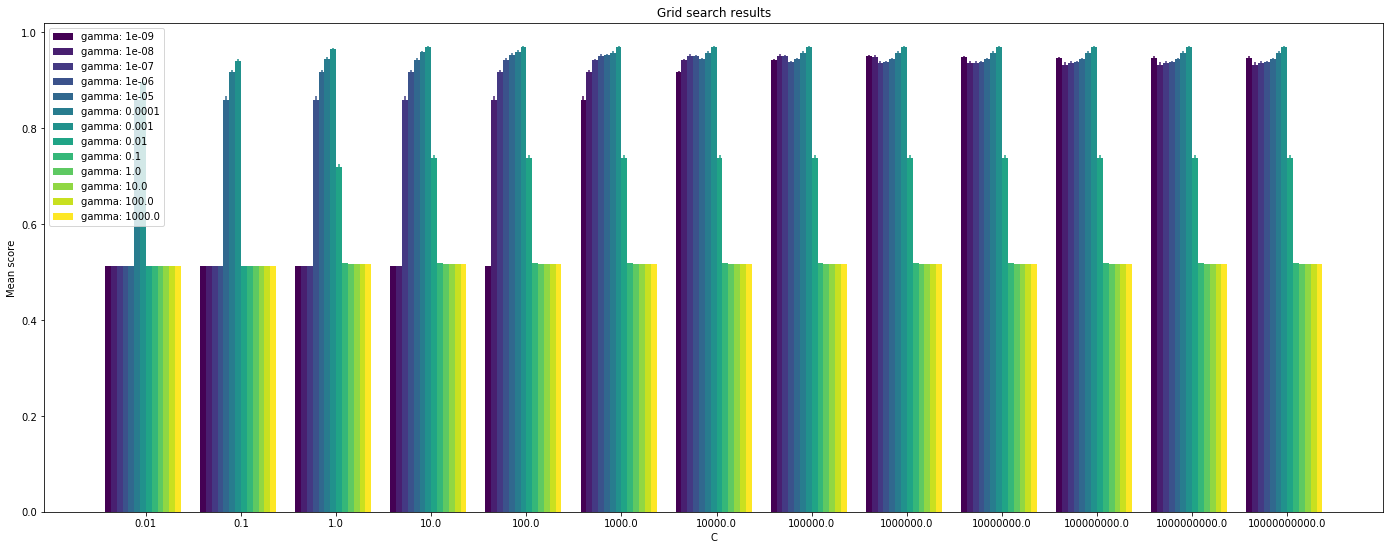

In [15]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [16]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
top_model = svm.SVC(C=10.0,gamma=0.001)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(top_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

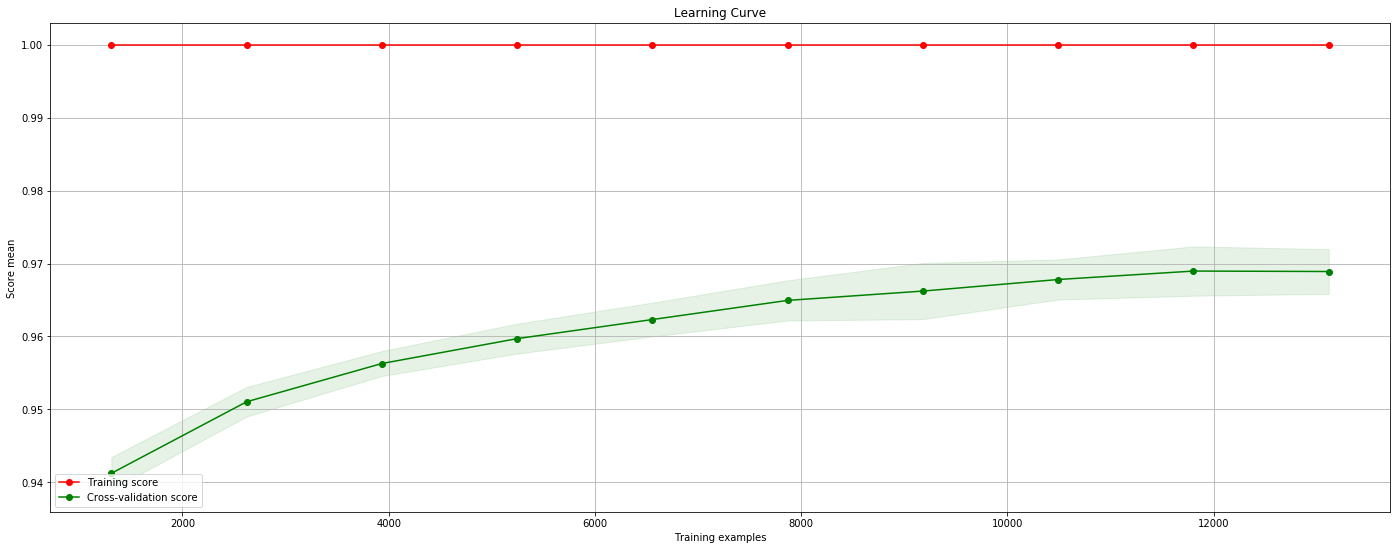

In [17]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()